# Import needed modules

In [1]:
!pip install -U numpy pandas
!pip install -U matplotlib seaborn
!pip install -U opencv-python pillow
!pip install -U scikit-learn
!pip install -U tensorflow

  Using cached numpy-2.4.1-cp311-cp311-macosx_14_0_arm64.whl.metadata (6.6 kB)
Using cached numpy-2.4.1-cp311-cp311-macosx_14_0_arm64.whl (5.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
  Using cached pillow-12.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached numpy-2.2.6-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-macosx_14_0_arm64.whl (5.4 MB)
Using cached pillow-12.1.0-cp311-cp311-macosx_11_0_arm64.whl (4.7 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 12.0.0
    Uninstalling pillow-12.0.0:


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [3]:
data_dir = 'blood_cancer_detection/data'
filepaths = []
labels = []

for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)

    # skip non-directories (e.g. .DS_Store)
    if not os.path.isdir(foldpath):
        continue

    # skip unwanted folders
    if fold in ['ig', 'neutrophil']:
        continue

    for file in os.listdir(foldpath):
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

df = pd.DataFrame({
    "filepaths": filepaths,
    "labels": labels
})

In [4]:
df

,filepaths,labels
0,blood_cancer_detection/data/basophil/BA_689200...,basophil
1,blood_cancer_detection/data/basophil/BA_883452...,basophil
2,blood_cancer_detection/data/basophil/BA_382161...,basophil
3,blood_cancer_detection/data/basophil/BA_175579...,basophil
4,blood_cancer_detection/data/basophil/BA_775722...,basophil
...,...,...
10863,blood_cancer_detection/data/platelet/PLATELET_...,platelet
10864,blood_cancer_detection/data/platelet/PLATELET_...,platelet
10865,blood_cancer_detection/data/platelet/PLATELET_...,platelet
10866,blood_cancer_detection/data/platelet/PLATELET_...,platelet


### **Split dataframe into train, valid, and test**

In [5]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8694 validated image filenames belonging to 6 classes.
Found 1304 validated image filenames belonging to 6 classes.
Found 870 validated image filenames belonging to 6 classes.


### **Show sample from train data**

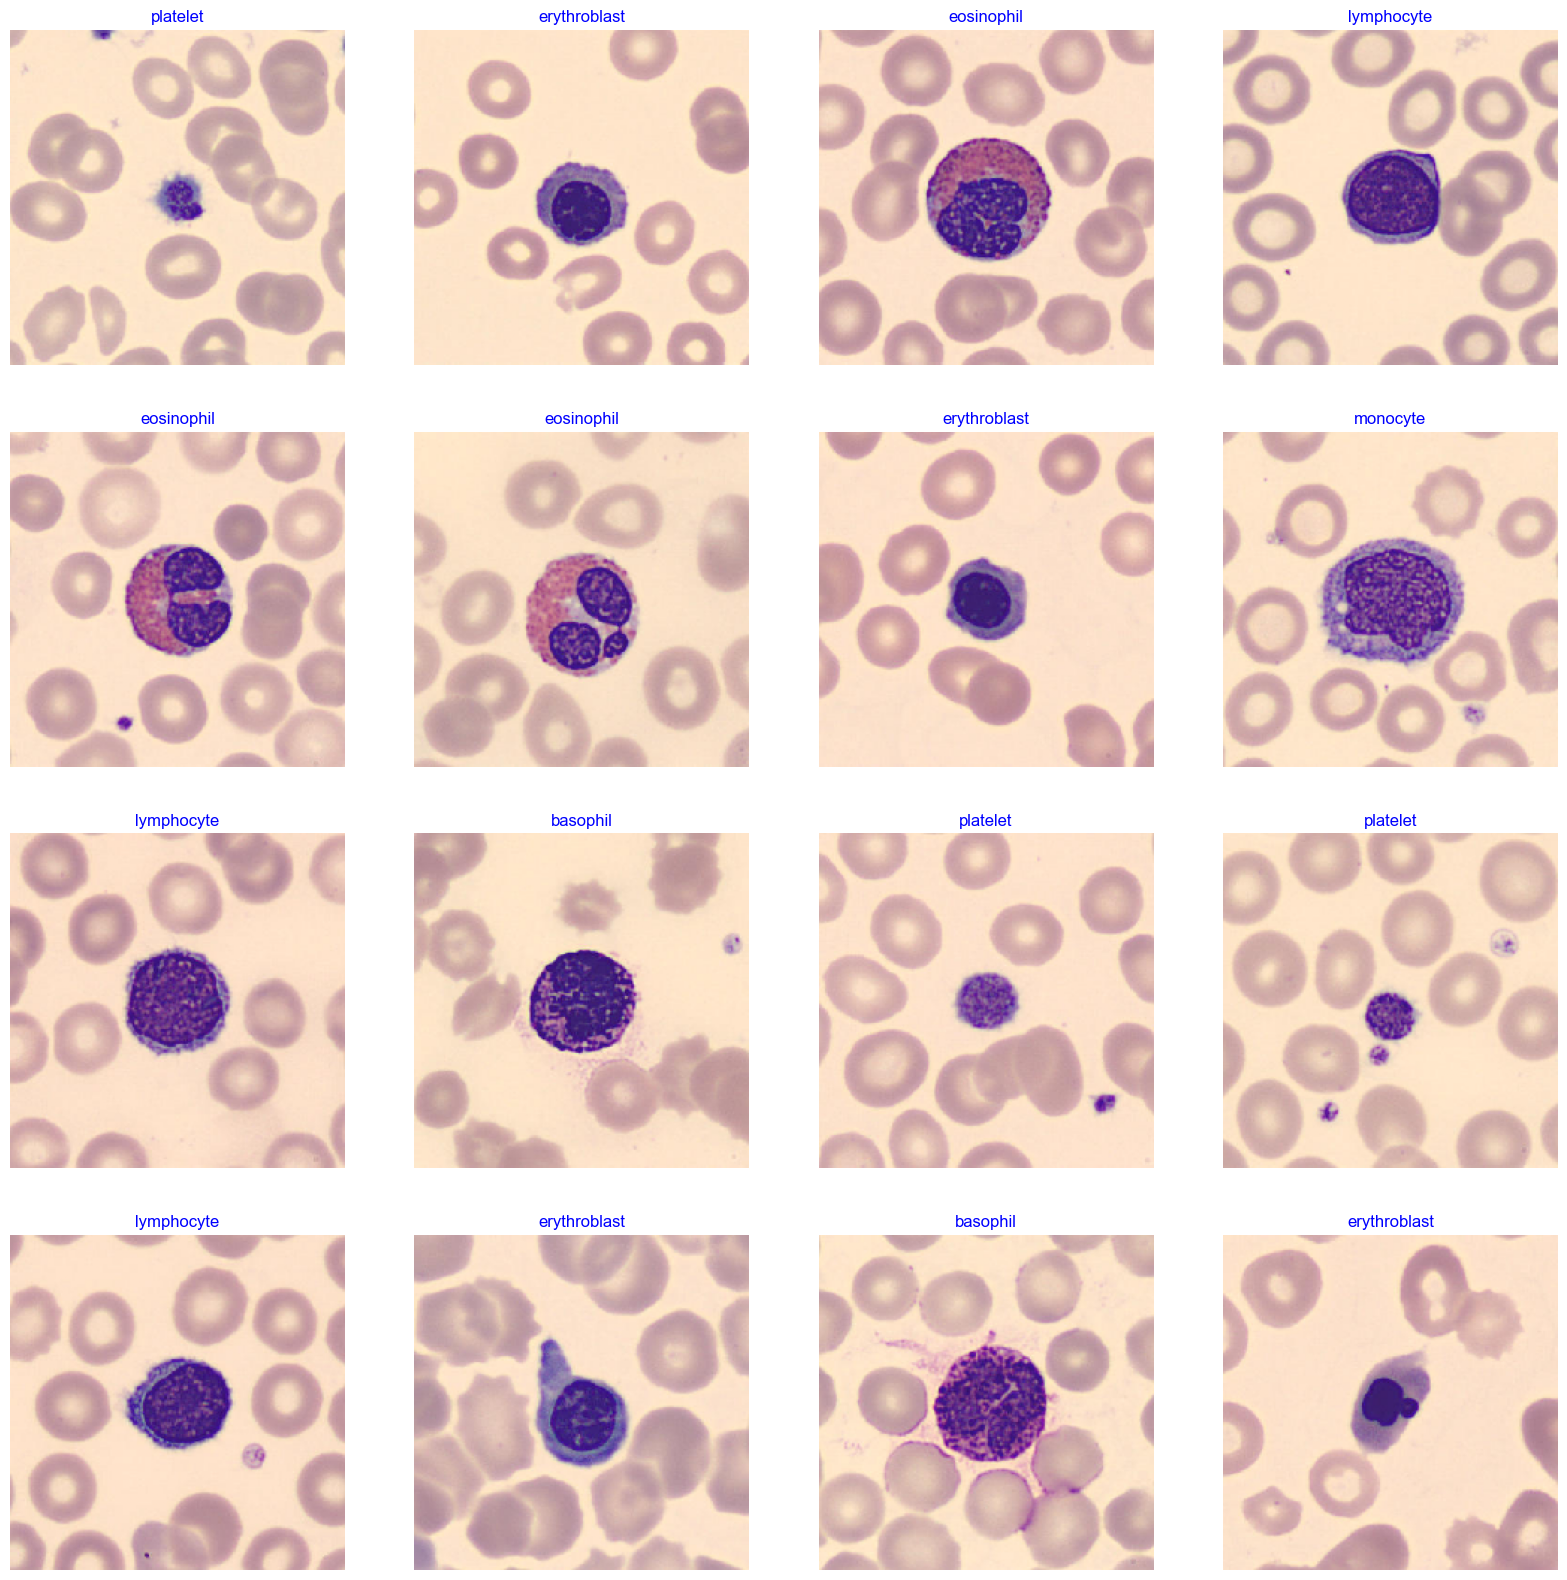

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [12]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(
        256,
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation='relu'
    ),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,693 (42.67 MB)

 Trainable params: 11,094,318 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

#### **Train model**

In [13]:
#epochs = 10
epochs = 3

history = model.fit(x = train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False)

Epoch 1/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 648s 1s/step - accuracy: 0.4509 - loss: 7.3489 - val_accuracy: 0.5184 - val_loss: 4.7798
Epoch 2/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 1101s 2s/step - accuracy: 0.4758 - loss: 3.7036 - val_accuracy: 0.5192 - val_loss: 2.7607
Epoch 3/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 1270s 2s/step - accuracy: 0.4714 - loss: 2.3347 - val_accuracy: 0.5207 - val_loss: 1.8979


#### **Display model performance**

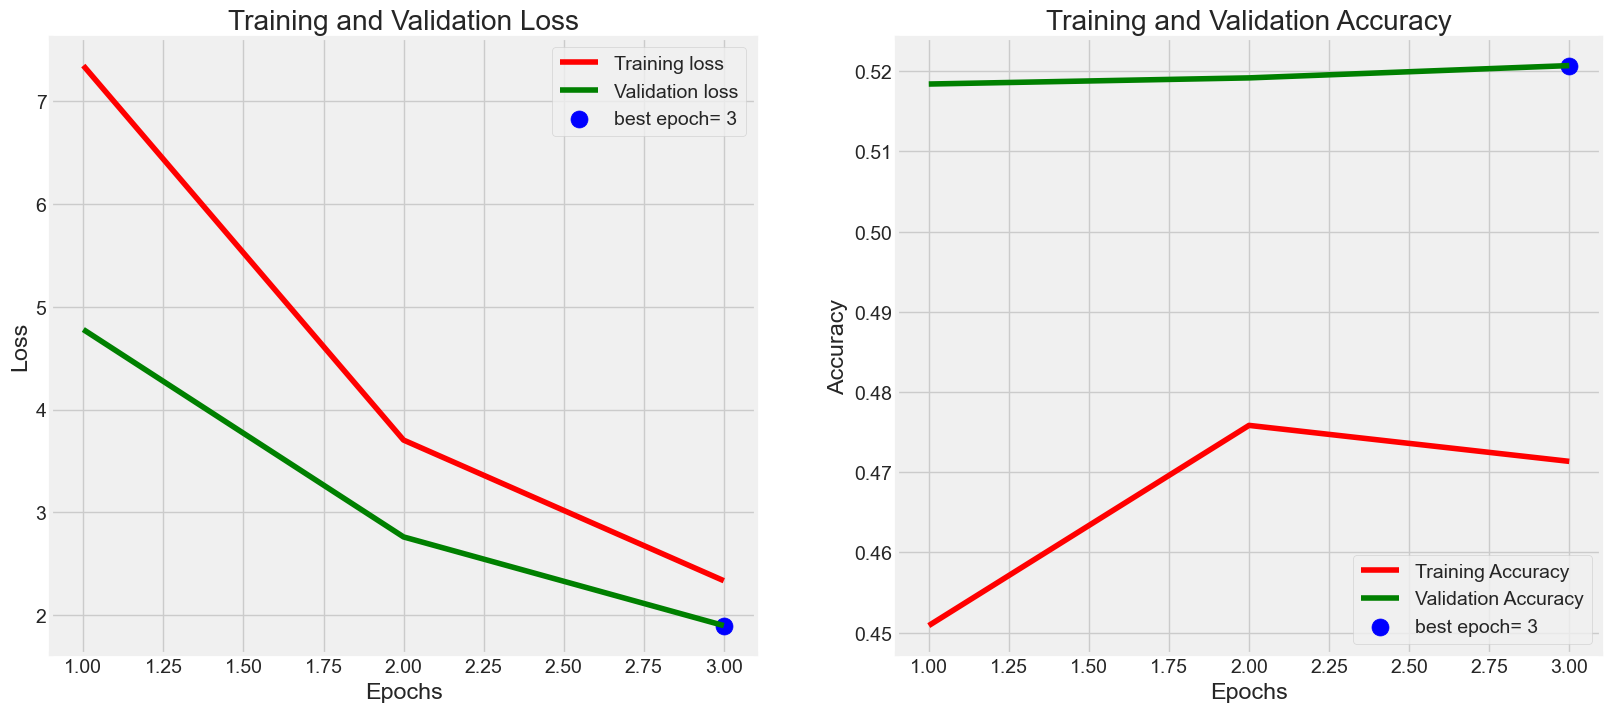

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.5167 - loss: 1.8811
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - accuracy: 0.5250 - loss: 1.9416
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 486ms/step - accuracy: 0.4792 - loss: 1.9452
Train Loss:  1.8810681104660034
Train Accuracy:  0.5166666507720947
--------------------
Validation Loss:  1.941556692123413
Validation Accuracy:  0.5249999761581421
--------------------
Test Loss:  1.9452446699142456
Test Accuracy:  0.4791666567325592


# **Get Predictions**

In [17]:
preds = model.predict(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 566ms/step


#### **Confusion Matrics and Classification Report**

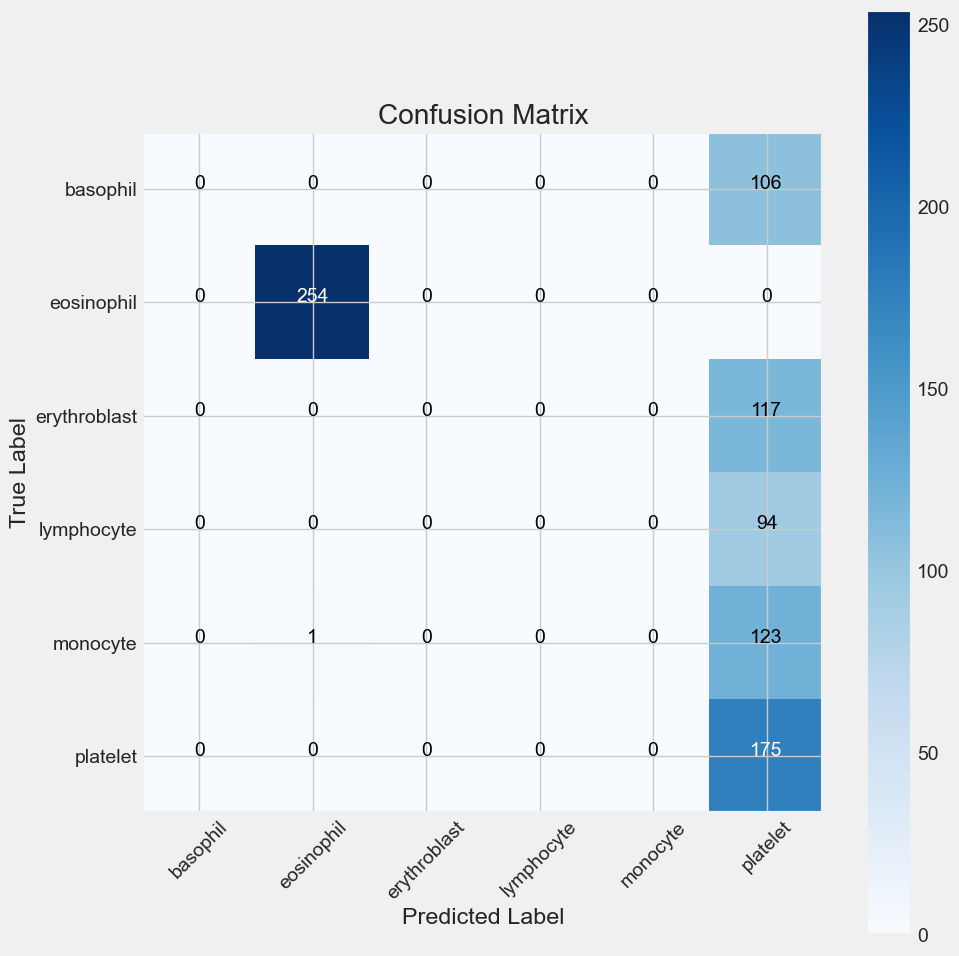

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       0.00      0.00      0.00       106
  eosinophil       1.00      1.00      1.00       254
erythroblast       0.00      0.00      0.00       117
  lymphocyte       0.00      0.00      0.00        94
    monocyte       0.00      0.00      0.00       124
    platelet       0.28      1.00      0.44       175

    accuracy                           0.49       870
   macro avg       0.21      0.33      0.24       870
weighted avg       0.35      0.49      0.38       870



#### **Save model**

In [15]:
#Save the model
model.save('Bloods.h5')

## **Prediction using loaded_model**

In [16]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Bloods.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [17]:
image_path = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/eosinophil/EO_100884.jpg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'IG', 'lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 3s 3s/step
Eosinophil


## Convert to tflite

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

print("model converted")

# Save the model. 
with open('Bloods.tflite', 'wb') as f:
    f.write(tflite_model)

model converted
